In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

# PATH = Path('../../data')
PATH = Path('/content/gdrive/My Drive/ml-practico/data')

# Load the data

Con lo que aprendimos del notebook anterior (explore the data)

In [ ]:
import pandas as pd

title_basics = pd.read_csv(PATH / 'title.basics.tsv', sep='\t')

movie_gross = pd.read_csv(PATH / 'movie_gross.csv')
# Calculamos el id de pelicula
movie_gross['tconst'] = movie_gross.movie_imdb_link.apply(lambda x: x.split('/')[4])
# Deduplicamos los registros
movie_gross = movie_gross.groupby('tconst').gross.max().reset_index()

title_ratings = pd.read_csv(PATH / 'title.ratings.tsv', sep='\t')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
from itertools import chain
from collections import Counter

def parse_genres(genres):
    if isinstance(genres, float) or genres == r'\N': return ['no-genre']
    else: return genres.split(',')
# si es un float no es un genre o si es \N le pongo no genre y sino los divido por coma (cada peli tiene mas de 1 genre)     

# Convertimos runtimeMinutes a float. No se puede tener una columna de tipo int con NaN
title_basics.runtimeMinutes = (
    title_basics.runtimeMinutes.apply(lambda x: np.nan if not x.isdigit() else x).astype(float)
)

title_basics['genres'] = title_basics.genres.apply(parse_genres)

In [ ]:
title_basics = title_basics[
    # Dejamos tvSpecial, video y tvMovie por ahora, vamos a ver de que se tratan
    ~title_basics.titleType.isin(['tvEpisode', 'tvSeries', 'tvMiniSeries', 'videoGame', 'tvShort', 'short'])
    # Que tengan valor de runtimeMinutes
    & ~title_basics.runtimeMinutes.isna()
    # Menos de 3 horas y media para no descartar a titanic
    & (title_basics.runtimeMinutes <= 3.5 * 60)
    # Descartamos los shorts en los generos (es un corto)
    & title_basics.genres.apply(lambda x: 'Short' not in x)
    
]

In [ ]:
# Juntamos todo

movies = (
    title_basics.merge(movie_gross, on='tconst', how='left')
                .merge(title_ratings, on='tconst', how='left')
)

len(movies)

545876

### Sanity check

Se ve igual que en el notebook anterior?

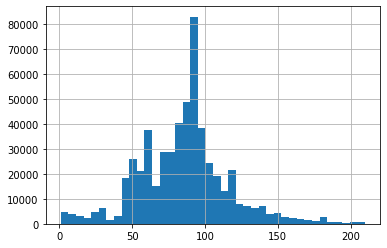

In [ ]:
movies.runtimeMinutes.hist(bins=40);

Sigue habiendo cosas cortitas. Deberiamos mirarlo en detalle si fuera un proyecto de verdad. Un largometraje dura por lo menos 60 minutos. Deberiamos descartar lo que no cumpla eso.

Miremos un caso individual (titanic)

In [ ]:
movies[movies.tconst == 'tt0120338']

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,gross,averageRating,numVotes
78839,tt0120338,movie,Titanic,Titanic,0,1997,\N,194.0,"[Drama, Romance]",658672302.0,7.8,1024063.0


# Hipótesis: el rating es buen predictor del gross

Nosotros tenemos el dato de gross (ganancia). Quedemonos solo con las pelis que tienen data de gross y veamos si hay un bias o no. 

In [ ]:
len(movies)

545876

In [ ]:
movies.head()
# se ve que tiene nan en gross

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,gross,averageRating,numVotes
0,tt0000009,movie,Miss Jerry,Miss Jerry,0,1894,\N,45.0,[Romance],NaN,5.9,154.0
1,tt0000147,movie,The Corbett-Fitzsimmons Fight,The Corbett-Fitzsimmons Fight,0,1897,\N,20.0,"[Documentary, News, Sport]",NaN,5.2,356.0
2,tt0000502,movie,Bohemios,Bohemios,0,1905,\N,100.0,[no-genre],NaN,3.8,6.0
3,tt0000574,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,0,1906,\N,70.0,"[Biography, Crime, Drama]",NaN,6.1,589.0
4,tt0000679,movie,The Fairylogue and Radio-Plays,The Fairylogue and Radio-Plays,0,1908,\N,120.0,"[Adventure, Fantasy]",NaN,5.2,37.0


In [ ]:
movies[movies.averageRating.isna()][:10]
# tmb hay nans en averageratings y numvotes

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,gross,averageRating,numVotes
11,tt0001592,movie,Ekspeditricen,Ekspeditricen,0,1911,\N,45.0,[no-genre],NaN,NaN,NaN
14,tt0001756,movie,Lucha por la herencia,Lucha por la herencia,0,1911,\N,92.0,[no-genre],NaN,NaN,NaN
21,tt0002094,movie,Charles IV,Charles IV,0,1912,\N,50.0,[no-genre],NaN,NaN,NaN
27,tt0002315,movie,El lobo de la sierra,El lobo de la sierra,0,1912,\N,76.0,[no-genre],NaN,NaN,NaN
29,tt0002425,movie,Paul J. Rainey's African Hunt,Paul J. Rainey's African Hunt,0,1912,\N,60.0,[Documentary],NaN,NaN,NaN
30,tt0002432,movie,Los Pirineos de Port-Bou a Andorra,Los Pirineos de Port-Bou a Andorra,0,1912,\N,58.0,[no-genre],NaN,NaN,NaN
33,tt0002459,movie,The Reward for Broncho Billy,The Reward for Broncho Billy,0,1912,\N,27.0,"[Drama, Western]",NaN,NaN,NaN
37,tt0002602,movie,The Secret of Adrianople,Adrianopels hemmelighed,0,1913,\N,3.0,[no-genre],NaN,NaN,NaN
38,tt0002625,movie,Ana Kadova,Ana Kadova,0,1913,\N,92.0,[no-genre],NaN,NaN,NaN
42,tt0002683,movie,The Black Snake,The Black Snake,0,1913,\N,32.0,[Drama],NaN,NaN,NaN


In [ ]:
# Only gross and rating data frame
ogr_df = movies.dropna(subset=['averageRating', 'numVotes', 'gross']).dropna()

In [ ]:
ogr_df[ogr_df.averageRating.isna()][:10]

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,gross,averageRating,numVotes


In [ ]:
ogr_df[ogr_df.gross.isna()][:10]

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,gross,averageRating,numVotes


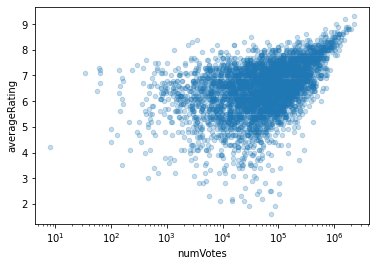

In [ ]:
# grafico general
# raiting promedio vs la cantidad de votos
# es importante el alpha cuando tengo muchos datos, asi cuando hay muchos se pone oscuro y si hay pocos es clarito
ogr_df.plot.scatter('numVotes', 'averageRating', alpha=0.25)
plt.xscale('log')

En general las peliculas que reciben muchos votos son buenas (tienen buen raiting). Hay una correlacion entre el numero de votos y el raiting. Esto explita un poco lo vamos a ver despues en los boxplots. 

In [ ]:
ogr_df['log(numVotes)'] = np.log10(ogr_df.numVotes)
# el logaritmo de la cantidad de votos.
# si ponemos directamente la cantidad de votos no se ve nada en el plot, la dispersion que tiene la cantidad de votos es enorme. Hay peliculas con 100 votos y peliculas con 1 millon de votos. Eso hace que se rompa la escala de colores

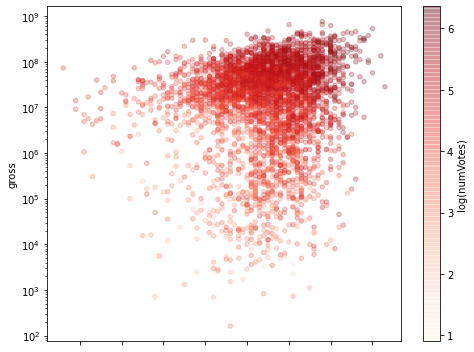

In [ ]:
ogr_df.plot.scatter('averageRating', 'gross', c='log(numVotes)', cmap='Reds', alpha=0.25, figsize=(7,5))
plt.yscale('log');
plt.tight_layout()

Hay bastante dispersion. No parece haber una correlacion directa, pero parece haber dos clusters diferenciados. Podrán explicarse con algun genero, u otra columna de los datos?

In [ ]:

ogr_df.plot.scatter?

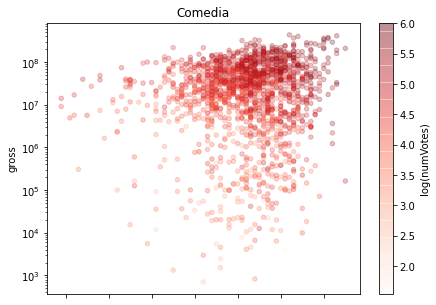

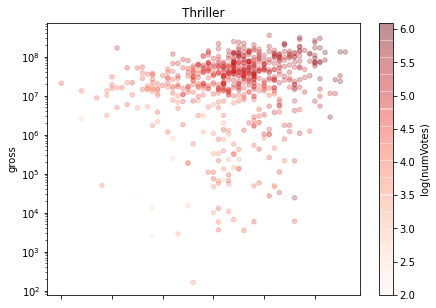

In [ ]:
(
    ogr_df[ogr_df.genres.apply(lambda x: 'Comedy'  in x)]
    .plot.scatter('averageRating', 'gross', c='log(numVotes)', cmap='Reds', alpha=0.25, figsize=(7,5))
)
plt.title("Comedia")
plt.yscale('log');
(
    ogr_df[ogr_df.genres.apply(lambda x: 'Thriller'  in x)]
    .plot.scatter('averageRating', 'gross', c='log(numVotes)', cmap='Reds', alpha=0.25, figsize=(7,5))
)
plt.title("Thriller")
plt.yscale('log');

Thriller tiene una pendiente linda y algunos nada que ver. Podria ser que el raiting sea una buena feature en relacion al gross. Nuestro caso de negocio no va a tener raiting, es una peli que no existe. Pero igual sirve como sanity check. 

Habrá mas como estos?

## **Habrá bias en la data que tiene gross?**

Tengo muy pocas pelis con datos de gross. Por eso me surge la pregunta. 

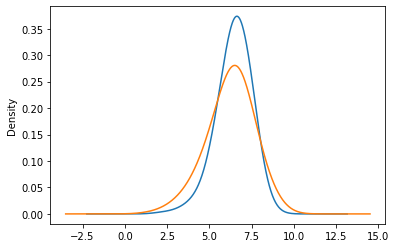

In [ ]:
# ploteo la densidad del average raiting de las que tienen gross (ogr) y del dataset completo (que incluye a las que tiene y no tienen gross)
ogr_df.averageRating.plot.density(bw_method=0.5) # solo las que tienen gross y average raiting
movies[~movies.averageRating.isna()].averageRating.plot.density(bw_method=0.5)

La media se respeta en ambas distribuciones pero las colas son diferentes. La naranjas es de todo el dataset y la azul es de las que tienen gross. La naranja tiene mas densidad en la cola izquierda y por eso la altura del pico es menor que la curva azul. Eso tmb se ve en el boxplot siguiente viendo que hay un monton de outliers en all movies abajo. 

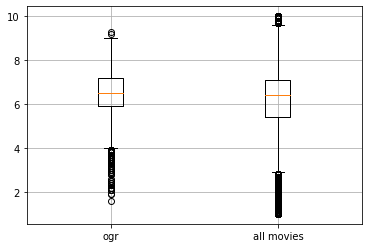

In [ ]:
plt.boxplot([ogr_df.averageRating, movies[~movies.averageRating.isna()].averageRating]);
plt.xticks([1, 2], ['ogr', 'all movies'])
plt.grid()

Si miramos numVotes, si hay una diferencia grande

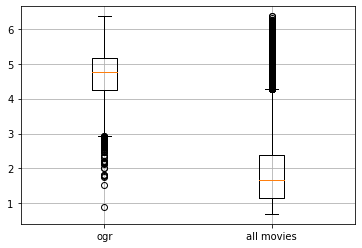

In [ ]:
plt.boxplot([np.log10(ogr_df.numVotes), np.log10(movies[~movies.averageRating.isna()].numVotes)]);
plt.xticks([1, 2], ['ogr', 'all movies'])
plt.grid()

(SOL) Solo las peliculas populares (con muchos votos) tienen gross.
Si miramos con gross (izquierda) la cantidad de votos es mayor (5 del eje y es 10^5). En general las peliculas con gross tienen 10^5 votos (la media). Mirando todas las peliculas (boxplot derecha) en general las peliculas tienen entre 10 y 10^2 votos. 

(PABLO)Pareciera que las colas de la distribucion no estan bien representadas.  En los boxplots de arriba vemos la distribucion de la cantidad de votos y vemos un bias enorme. Esta en logaritmo en base 10 para que se pueda ver. Las que no tenemos gross (izquierda) son peliculas no famosas (pocos numero de votos) y las que tenemos gross (derecha) son peliculas muy famosas (muchos votos).   

Tiene sentido decir, bueno esta data de gross no la vamos a usar. 

## Tiene sentido plantarlo como clasificacion: P(gross > X dollars)?

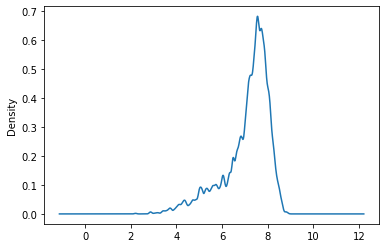

In [ ]:
np.log10(ogr_df.gross).plot.density(bw_method=0.05)

Parece haber un **sesgo grande** en la eleccion de las peliculas de movies_gross como para utilizarla para este proposito

Volvemos con el equipo de negocio y les proponemos predecir el rating como proxy. Se sienten comodes

# **Si utilizamos la probabilidad de que reciba al menos un rating de X?**

Vamos a tratar de usar el raiting (y no el gross) y hacer un modelo muy sencillo.

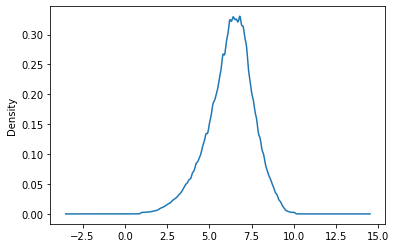

In [ ]:
# distribucion del raiting
movies.dropna(subset=['averageRating']).averageRating.plot.density(bw_method=0.05)

Vemos que la distribucion cubre desde 2.5 estrellas hasta 9,5 estrellas (aprox).

In [ ]:
# La distribucion es amplia, parece ser interesante
np.percentile(movies.averageRating.dropna(), [25, 50, 75, 85, 95])

array([5.4, 6.4, 7.1, 7.6, 8.3])

El percentil 25 corresponde a 5.4, es decir, el 75% de las pelis tienen por lo menos un raiting de 5.4 estrellas. 
El percentil 95 corresponde a 8.3, es decir, solo el 5% de las pelis tienen  un raiting de mas de 8.3 estrellas. 

In [ ]:
movies.head() # esta el gross que no lo vamos a usar

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,gross,averageRating,numVotes
0,tt0000009,movie,Miss Jerry,Miss Jerry,0,1894,\N,45.0,[Romance],NaN,5.9,154.0
1,tt0000147,movie,The Corbett-Fitzsimmons Fight,The Corbett-Fitzsimmons Fight,0,1897,\N,20.0,"[Documentary, News, Sport]",NaN,5.2,356.0
2,tt0000502,movie,Bohemios,Bohemios,0,1905,\N,100.0,[no-genre],NaN,3.8,6.0
3,tt0000574,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,0,1906,\N,70.0,"[Biography, Crime, Drama]",NaN,6.1,589.0
4,tt0000679,movie,The Fairylogue and Radio-Plays,The Fairylogue and Radio-Plays,0,1908,\N,120.0,"[Adventure, Fantasy]",NaN,5.2,37.0


## 🤔 Para pensar 

Cuantos votos tiene que tener una pelicula para usarla en training / testing? Supongamos que predecimos las estrellitas. Tenemos peliculas con 6 votos, donde ponemos el corte? con que criterio? A partir de cuantos votos empiezo a considerar una pelicula. 

Qué metrica usamos? 
* Accuracy? 
* ROC AUC?
* f1?
* Otra?

A priori predecir las estrellitas no es un problema de clasificacion. Las estrellitas es un numero entre 1 y 10. Uso error cuadratico medio?

**Una que podemos hacer es predecir la probabilidad de que tenga mas de cierta cantidad de raiting. Por ejemplo la probabiliadad de que tenga mas de 7.5 de raiting (es el 85% percentil). Esta es una opcion de framing, hay muchas mas posibilidades.**

## **Train test set split**

Aca hay una nocion de tiempo. En la vida real vamos a tener los datos de las peliculas previas del pasado y no las del futuro. Vamos a querer predecir las peliculas que todavia no salieron. No tiene sentido hacer un shuffling random para dividir entre train y test. Aparte si hacemos shuffling random, si tengo un actor que hasta cierto tiempo no era conocido y despues la pego y ponemos la pelicula en donde la pego en el training y en el test pongo las peliculas cuando no era conocido , vamos a estar filtrando esa informacion. Nos va a hacer a pensar que nos va bien en el development set y eso es en realidad porque estamos teniendo data/information leakage. Una buena forma es partir por fechas entre training y test.  

In [ ]:
# anios de string a numero. 
# le aplica a cada valor de startyear la funcion lambda
movies['startYear'] = movies['startYear'].apply(lambda x: np.nan if x == r'\N' else int(x)) # x es el year en string

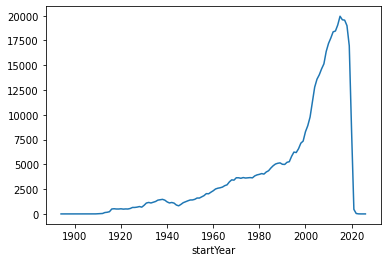

In [ ]:
movies.groupby('startYear').tconst.agg('count').plot()

Queremos peliculas del 1900 para predecir el raiting? Hay un sesgo grande. Descarto todo lo previo al 1970.

In [ ]:
movies = movies[movies.startYear > 1970].dropna(subset=['averageRating'])
# tambien descarta los nans

In [ ]:
train_df = movies[movies.startYear <= 2017]
test_df = movies[movies.startYear > 2017]

len(train_df), len(test_df), len(test_df) / len(train_df)

(222125, 21170, 0.09530669667979741)

test set de un 10% de los datos. No tengo un development set. 

In [ ]:
y_train = (train_df.averageRating >= 7.5).values # nuestro target es que tenga mas de 7.5
y_test = (test_df.averageRating >= 7.5).values

In [ ]:
y_train[:3] # false suma 0, true suma 1 

array([False, False, False])

In [ ]:
y_train.sum() / len(y_train), y_test.sum() / len(y_test)

(0.18537760270118175, 0.1917808219178082)

En train un 18% tiene una puntuacion mayor a 7.5 y en test un 19% tiene mas de 7.5. Estos numeros tienen que ser parecidos. Cuando hacemos empirical risk minimization estamos asumiendo que la distribucion de los datos con los que estamos testeando es la misma que la de los datos con los que entrenamos. Aca seguro que las distribuciones no son iguales, pero si no partimos de esa forma el training y test set vamos a tener information leakage y no queremos eso. Queremos que el modelo funcione bien prediciendo peliculas del futuro. 



## **Feature engineering 101**

## Hay relacion entre el genero y la pelicula?

**Cuando hacemos esto en sklearn es buena practica salir de pandas y hacer todo con listas de diccionarios.**

In [ ]:
# Vamos a usar todo como listas de diccionarios para poder usar el ecosistema de sklearn de forma sencilla

train_docs = train_df.to_dict(orient='records')
test_docs = test_df.to_dict(orient='records')

In [ ]:
train_docs[:10] #lista de diccionarios

[{'averageRating': 5.4,
  'endYear': '\\N',
  'genres': ['no-genre'],
  'gross': nan,
  'isAdult': 0,
  'numVotes': 12.0,
  'originalTitle': 'La tierra de los toros',
  'primaryTitle': 'La tierra de los toros',
  'runtimeMinutes': 60.0,
  'startYear': 2000.0,
  'tconst': 'tt0015414',
  'titleType': 'movie'},
 {'averageRating': 6.2,
  'endYear': '\\N',
  'genres': ['Drama', 'Mystery', 'Romance'],
  'gross': nan,
  'isAdult': 0,
  'numVotes': 20.0,
  'originalTitle': 'Dama de noche',
  'primaryTitle': 'Dama de noche',
  'runtimeMinutes': 102.0,
  'startYear': 1993.0,
  'tconst': 'tt0015724',
  'titleType': 'movie'},
 {'averageRating': 5.6,
  'endYear': '\\N',
  'genres': ['Comedy', 'Musical'],
  'gross': nan,
  'isAdult': 0,
  'numVotes': 15.0,
  'originalTitle': 'Frivolinas',
  'primaryTitle': 'Frivolinas',
  'runtimeMinutes': 80.0,
  'startYear': 2014.0,
  'tconst': 'tt0016906',
  'titleType': 'movie'},
 {'averageRating': 7.0,
  'endYear': '\\N',
  'genres': ['Drama', 'Romance'],
  'gr

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
# el primer descriptor que voy a hacer (primeras features) es dummies para el genero
# en sklearn se hace haciendo una clase que herede de BaseEstimator y TransformerMixin
# hay que escribir las funciones fit y transform 
# el fit entrena la transformacion. Hay transformaciones entrenadas y transformaciones no entrenadas. Hay transformaciones sencillas como que le reste la media, que standarice las variables (del traingin set). En el fit nos guardamos  la varianza y la media de las variables.
class GenreDummies(BaseEstimator, TransformerMixin):
    def fit(self, X, y): 
      return self

    def transform(self, X): # en el transform restamos la media y dividimos por el desvio estandar
        res = []
        for e in X:
            res.append({g: 1 for g in e['genres']})
        return res  
        # transform pone un 1 en los generos que tiene la peli      

In [ ]:
[e['genres'] for e in train_docs[:10]]

[['no-genre'],
 ['Drama', 'Mystery', 'Romance'],
 ['Comedy', 'Musical'],
 ['Drama', 'Romance'],
 ['Comedy', 'Fantasy', 'Romance'],
 ['Drama', 'War'],
 ['Documentary', 'War'],
 ['Drama'],
 ['Horror'],
 ['Drama', 'Fantasy']]

In [ ]:
GenreDummies().transform(train_docs[:10]) # lo convierte en un diccionario 
# luego voy a convertir estos diccionarios en vectores
# con los diccionarios solo digo lo que es uno 

[{'no-genre': 1},
 {'Drama': 1, 'Mystery': 1, 'Romance': 1},
 {'Comedy': 1, 'Musical': 1},
 {'Drama': 1, 'Romance': 1},
 {'Comedy': 1, 'Fantasy': 1, 'Romance': 1},
 {'Drama': 1, 'War': 1},
 {'Documentary': 1, 'War': 1},
 {'Drama': 1},
 {'Horror': 1},
 {'Drama': 1, 'Fantasy': 1}]

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [ ]:
# un pipeline es una forma de agrupar transformaciones y ponerlas todas juntas
# tiene la ventaja que despues lo puedo guardar en disco (uso pickle) y luego lo puedo levantar
#este pipeline incluye todo para agarrar una peli, procesarla y devolverte el resultado del modelo
# agarra la peli y le calcula los genredummies (el diccionario), despues hace el dictvectorizer, despues hace una standarizacion y despues hace una regresion logistica
pipe = make_pipeline(
    GenreDummies(), DictVectorizer(sparse=False), 
  #  StandardScaler(), #no hace falta aca
  #  LogisticRegression() 
)

pipe.fit(train_docs, y_train);

In [ ]:
# comente la regresion logistica arriba para mostrar algo
pipe.transform(train_docs[:10])
# el primero es todos ceros y un uno en la ultima posicion que corresponde a no genre

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],


In [ ]:
#veamos que el ultimo es nogenre
pipe.named_steps['dictvectorizer'].feature_names_
# feature_names_ es algo que se entrena cuando le hago el fit . Tiene que recorrer los diccionarios y ver que cosas aparecen en el diccionario.

['Action',
 'Adult',
 'Adventure',
 'Animation',
 'Biography',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Family',
 'Fantasy',
 'Game-Show',
 'History',
 'Horror',
 'Music',
 'Musical',
 'Mystery',
 'News',
 'Reality-TV',
 'Romance',
 'Sci-Fi',
 'Sport',
 'Talk-Show',
 'Thriller',
 'War',
 'Western',
 'no-genre']

In [ ]:
# sin logistic regresion comentada
# un pipeline es una forma de agrupar transformaciones y ponerlas todas juntas
# tiene la ventaja que despues lo puedo guardar en disco (uso pickle) y luego lo puedo levantar
#este pipeline incluye todo para agarrar una peli, procesarla y devolverte el resultado del modelo
# agarra la peli y le calcula los genredummies (el diccionario), despues hace el dictvectorizer, despues hace una standarizacion y despues hace una regresion logistica
pipe = make_pipeline(
    GenreDummies(), DictVectorizer(sparse=False), 
  #  StandardScaler(), #no hace falta aca
    LogisticRegression()
)

pipe.fit(train_docs, y_train);

In [ ]:
#pipe
pipe.predict(train_docs[:10])

array([False, False, False, False, False, False, False, False, False,
       False])

Los false significan que la pelicula tiene menos de 7.5 de puntuacion y los true que tiene mas de 7.5

In [ ]:
pipe.predict_proba(train_docs[:10])
# primera columna es la probabilidad de que sea false/clase 0 (tenga menos de 7.5)

array([[0.79082994, 0.20917006],
       [0.91314297, 0.08685703],
       [0.78407111, 0.21592889],
       [0.90632199, 0.09367801],
       [0.92903699, 0.07096301],
       [0.83539081, 0.16460919],
       [0.56321449, 0.43678551],
       [0.84906416, 0.15093584],
       [0.95850593, 0.04149407],
       [0.86791588, 0.13208412]])

In [ ]:
#calculemos alguna metrica. La roc_auc es independiente del umbral/threshold 
from sklearn.metrics import roc_auc_score
# recibe el pipe y devuelve el roc_auc en train y test
# test_pipe no tiene como parametros y_train, train_docs, y_test ,test_docs: son variables globales. ESTO ES UNA MUY MALA PRACTICA
def test_pipe(pipe):
    return {
        'train_auc': roc_auc_score(y_train, pipe.predict_proba(train_docs)[:, 1]),
        'test_auc': roc_auc_score(y_test, pipe.predict_proba(test_docs)[:, 1])
    }

In [ ]:
test_pipe(pipe)

{'test_auc': 0.7097893735982471, 'train_auc': 0.7415243791848622}

Le esta yendo mejor en training que en test, pero para nosotros no esta overfitteando. Tiene sentido que le vaya mejor en training que en test.

## **Cómo controlamos por el año?**

Podemos meter una feature mas. Tiene sentido que controlemos por el anio?

Siempre vamos a querer predecir sobre peliculas que van a salir en el futuro. Entonces por que tendria sentido tener como feature el anio en el que salio la pelicula? Tal vez porque hace 5 anios la gente votaba distinto y hay un sesgo. Si yo le meto el anio al modelo puedo hacer que el modeloe cancele ese sesgo.

In [ ]:
from datetime import datetime
from sklearn.base import BaseEstimator, TransformerMixin

# yearsago es un transformer. Lo que hace es: 
class YearsAgo(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.now = datetime.now().year # hoy que fecha es 
        
    def fit(self, X, y): return self

    def transform(self, X):
        res = []
        for e in X:
            res.append({'years_ago': self.now - int(e['startYear'])})
        return res # luego transforma cada pelicula haciendo la resta de hoy que fecha es menor el start year de la peli
# tengo el dato de hace cuantos anios es la peli

In [ ]:
from sklearn.pipeline import make_union
# make union une los anios con los generos: unio los dos features
pipe = make_pipeline(
    make_union(
        make_pipeline(YearsAgo(), DictVectorizer(sparse=False)), # lo apago comentando esta linea
        make_pipeline(GenreDummies(), DictVectorizer(sparse=False))
    ),
#    StandardScaler(),
    LogisticRegression()
)

pipe.fit(train_docs, y_train);

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Nos tira un warning que entreno y que no convirgio despues de hacer el numero maximo de iteraciones de optimizacion por gradiente. No llego al criterio de corte para los parametros para poder decir que convirgio.

In [ ]:
test_pipe(pipe)

{'test_auc': 0.7110014165080772, 'train_auc': 0.7418631483166699}

Algo muy chiquito mejoro, pero es bastante insignificante. No afecta mucho la metrica.

**Challenge**: esto realmente controla algo? sirve para algo?

## Cómo podemos incorporar información de la crew?

### ETL

In [ ]:
principals_df = pd.read_csv(PATH / 'title.principals.tsv', sep='\t')

In [ ]:
principals_df.head() # 41 millones de filas
#nconst es el nombre de la persona 
# la categoria es es actor, actress, director

,tconst,ordering,nconst,category,job,characters
0,tt0000001,1,nm1588970,self,\N,"[""Self""]"
1,tt0000001,2,nm0005690,director,\N,\N
2,tt0000001,3,nm0374658,cinematographer,director of photography,\N
3,tt0000002,1,nm0721526,director,\N,\N
4,tt0000002,2,nm1335271,composer,\N,\N


In [ ]:
principals_df.category.value_counts()

actor                  9428011
actress                7087536
self                   6992466
writer                 5443248
director               4739306
producer               2533985
cinematographer        1472541
composer               1461940
editor                 1375324
production_designer     302528
archive_footage         245691
archive_sound             2605
Name: category, dtype: int64

En las peliculas hay mas de un director

El director puede estar en ordering random 

ejemplos tt4898864 (10 directores)

titanic tt0120338 director en ordering 5 

Empecemos con los directores. Hay q hacer un preprocessing. Quiero calcularle features al director.



In [ ]:
# Me quedo solo con los que fueron directores
movies_directors = principals_df[principals_df.category == 'director'].copy()
movies_directors[:10]

,tconst,ordering,nconst,category,job,characters
1,tt0000001,2,nm0005690,director,\N,\N
3,tt0000002,1,nm0721526,director,\N,\N
5,tt0000003,1,nm0721526,director,\N,\N
9,tt0000004,1,nm0721526,director,\N,\N
13,tt0000005,3,nm0005690,director,\N,\N
15,tt0000006,1,nm0005690,director,\N,\N
18,tt0000007,3,nm0005690,director,\N,\N
19,tt0000007,4,nm0374658,director,\N,\N
22,tt0000008,2,nm0005690,director,\N,\N
27,tt0000009,4,nm0085156,director,\N,\N


In [ ]:
# Calculo un ranking por pelicula segun el ordering
movies_directors['director_rank'] = (
    movies_directors.sort_values('ordering')
                    .groupby('tconst')
                    .cumcount()
)

In [ ]:
movies_directors[:10] # tiene una columna mas que es director_rank

,tconst,ordering,nconst,category,job,characters,director_rank
1,tt0000001,2,nm0005690,director,\N,\N,0
3,tt0000002,1,nm0721526,director,\N,\N,0
5,tt0000003,1,nm0721526,director,\N,\N,0
9,tt0000004,1,nm0721526,director,\N,\N,0
13,tt0000005,3,nm0005690,director,\N,\N,0
15,tt0000006,1,nm0005690,director,\N,\N,0
18,tt0000007,3,nm0005690,director,\N,\N,0
19,tt0000007,4,nm0374658,director,\N,\N,1
22,tt0000008,2,nm0005690,director,\N,\N,0
27,tt0000009,4,nm0085156,director,\N,\N,0


In [ ]:
# Me quedo con el "director principal" por pelicula
movies_directors = movies_directors[movies_directors.director_rank == 0]

In [ ]:
# Sanity check, no debería haber repetidos
movies_directors.tconst.value_counts().max()

1

In [ ]:
# me puedo armar un mapping 
# me quedo solo con la columna del director
movies_directors = (
    movies_directors.rename(columns={'nconst': 'director'})
    [['tconst', 'director']]
)

In [ ]:
# Tenemos un mapping pelicula -> director
movies_directors.head()

,tconst,director
1,tt0000001,nm0005690
3,tt0000002,nm0721526
5,tt0000003,nm0721526
9,tt0000004,nm0721526
13,tt0000005,nm0005690


In [ ]:
#mergeo lo anterior con el director que sacamos del archivo principa;
train_df = train_df.merge(movies_directors, on='tconst', how='left').fillna('-')  #how='left' para que no borre pelis si no las encuentra
test_df = test_df.merge(movies_directors, on='tconst', how='left').fillna('-')

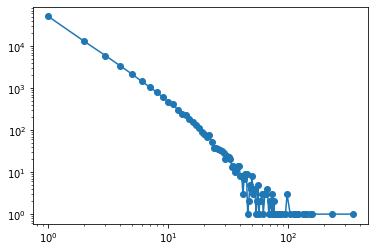

In [ ]:
# Distribución de cantidad de peliculas por director

director_movies_distr = (
    train_df[train_df.director != '-']
            .director
            .value_counts()
            .value_counts()
            .sort_index()
)

director_movies_distr.plot(style='-o', logx=True, logy=True)

Es una distribucion de cola pesada. La gran mayoria dirigieron 1 pelicula. 10^5 personas dirigieron 1 peli. 

In [ ]:
(director_movies_distr.cumsum() / director_movies_distr.sum()).head(10)

1     0.643312
2     0.803722
3     0.873731
4     0.912310
5     0.935839
6     0.951437
7     0.962051
8     0.969871
9     0.976061
10    0.980375
Name: director, dtype: float64

el 64% dirigio una peli

In [ ]:
(train_df.director == '-').sum() / len(train_df)
# el 10% no sabiamos quien era el director

0.0851952729319077

El 9% de los casos no tenemos info del director.

La mayoria (64%) de los directores hicieron una peli nada mas

In [ ]:
# Sanity check: como se ve titanic?
train_df[train_df.tconst == 'tt0120338']

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,gross,averageRating,numVotes,director
35537,tt0120338,movie,Titanic,Titanic,0,1997.0,\N,194.0,"[Drama, Romance]",6.58672e+08,7.8,1024063.0,nm0000116


In [ ]:
train_df= train_df.rename(columns={'directory':'director'})
#para renombrar una columna

In [ ]:
(train_df.director.value_counts() >= 2).sum()
#cuantos directores tuvieron mas que dos peliculas

31426

### Transformer & experiments

calculemos features a los directores. Si alguien dirigio una sola pelicula, no puedo calcularle features... muy poca estadistica.



In [ ]:
train_df.director.nunique()
# hay 82,000 personas que tuvieron un rol de director

82243

Si yo mando el nombre del director directamente como feature al modelo de regresion logistica, nuestro feature vector va a tener 82,000 dimensiones. El model complexity del modelo es 82,000. Y cuando entrene y ponga a alguien que dirigio 1 sola pelicula y le fue bien, que puedo decir de eso? no dirigio otra pelicula. Las chances de overfittear son altisimas. 

Entonces vamos a calcularle features a los directores. 

In [ ]:
from collections import Counter

class DirectorFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, min_cnt_movies = 2): #min_cnt_movies es un hiperparametro que dice el numero minimo de pelis q tiene que tener un director para ser considerado 
        self.min_cnt_movies = min_cnt_movies
        
    def fit(self, X, y): 
        # Llevamos las cosas de nuevo a un DataFrame y calculamos features por director
        # en vez de poner al nombre del director como feature, estoy poniendo como features el numero de pelis, el raiting minimo, etc. Es un vector de tamanio 7 
        directors_stats = (
            pd.DataFrame(X)
                .groupby('director')
                .agg(
                    n_films=('tconst', 'count'), #cuantas pelis dirigio
                    min_rating=('averageRating', 'min'), # el raiting minimo
                    avg_rating=('averageRating', 'mean'), # el raiting promedio
                    max_rating=('averageRating', 'max'), #el raiting maximo
                    min_votes=('numVotes', 'min'), 
                    avg_votes=('numVotes', 'mean'),
                    max_votes=('numVotes', 'max'),
            )
        )

        # Guardamos las estadisticas
        self.directors_stats_ = directors_stats

        # Diccionario con los datos para los directores comunes, tiene el vector de features
        self.directors_stats_lk_ = (
            directors_stats[directors_stats.n_films >= self.min_cnt_movies].to_dict(orient='index')
        )

        # Valor default para los que consideramos que tenemos demasiado poca data. Para los que dirigieron menos de 2 pelis armo para cada uno el vector de features, los prmomedio todos y a todos les pongo el vector promedio de features
        self.default_ = directors_stats[directors_stats.n_films < self.min_cnt_movies].mean(0).to_dict()
        if self.min_cnt_movies > 1:
            self.default_ = directors_stats[directors_stats.n_films < self.min_cnt_movies].mean(0).to_dict()
        else:
            self.default_ = directors_stats.mean(0).to_dict()
        return self
    # el fit me devuelve un diccionario con el director y su vector de features
    def transform(self, X):
        res = []
        for e in X: # para cada ejemplo de la lista de diccionarios
            if e['director'] in self.directors_stats_lk_:
                res.append(self.directors_stats_lk_[e['director']])
            else:
                res.append(self.default_)
        return res            

In [ ]:
# hay que hacerlo porque train_docs y test_docs no tienen director
# llevo a listas de diccionarios de nuevo
train_docs=train_df.to_dict(orient='records')
test_docs=test_df.to_dict(orient='records')

In [ ]:
# Lo importante de estandarizar las variables con una regresion logistica!
pipe = make_pipeline(
    DirectorFeatures(), DictVectorizer(sparse=False), LogisticRegression()
)

pipe.fit(train_docs, y_train);
test_pipe(pipe)

{'test_auc': 0.44785105359985955, 'train_auc': 0.2983973408531079}

Me da mejor en test que en training. Me da bajo. numero de votos va de 100 a 10^5 eso vuelve loco a la regresion logistica. Lo que puedo hacer es eliminar numero de votos o estandarizarlos. 

In [ ]:
from collections import Counter

class DirectorFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, min_cnt_movies = 2): #min_cnt_movies es un hiperparametro que dice el numero minimo de pelis q tiene que tener un director para ser considerado 
        self.min_cnt_movies = min_cnt_movies
        
    def fit(self, X, y): 
        # Llevamos las cosas de nuevo a un DataFrame y calculamos features por director
        # en vez de poner al nombre del director como feature, estoy poniendo como features el numero de pelis, el raiting minimo, etc. Es un vector de tamanio 7 
        directors_stats = (
            pd.DataFrame(X)
                .groupby('director')
                .agg(
                    n_films=('tconst', 'count'), #cuantas pelis dirigio
                    min_rating=('averageRating', 'min'), # el raiting minimo
                    avg_rating=('averageRating', 'mean'), # el raiting promedio
                    max_rating=('averageRating', 'max'), #el raiting maximo
                    # min_votes=('numVotes', 'min'), 
                    # avg_votes=('numVotes', 'mean'),
                    # max_votes=('numVotes', 'max'),
            )
        )

        # Guardamos las estadisticas
        self.directors_stats_ = directors_stats

        # Diccionario con los datos para los directores comunes, tiene el vector de features
        self.directors_stats_lk_ = (
            directors_stats[directors_stats.n_films >= self.min_cnt_movies].to_dict(orient='index')
        )

        # Valor default para los que consideramos que tenemos demasiado poca data. Para los que dirigieron menos de 2 pelis armo para cada uno el vector de features, los prmomedio todos y a todos les pongo el vector promedio de features
        self.default_ = directors_stats[directors_stats.n_films < self.min_cnt_movies].mean(0).to_dict()
        if self.min_cnt_movies > 1:
            self.default_ = directors_stats[directors_stats.n_films < self.min_cnt_movies].mean(0).to_dict()
        else:
            self.default_ = directors_stats.mean(0).to_dict()
        return self
    # el fit me devuelve un diccionario con el director y su vector de features
    def transform(self, X):
        res = []
        for e in X: # para cada ejemplo de la lista de diccionarios
            if e['director'] in self.directors_stats_lk_:
                res.append(self.directors_stats_lk_[e['director']])
            else:
                res.append(self.default_)
        return res            

In [ ]:
# Lo importante de estandarizar las variables con una regresion logistica!
pipe = make_pipeline(
    DirectorFeatures(min_cnt_movies=5), DictVectorizer(sparse=False), LogisticRegression()
)

pipe.fit(train_docs, y_train);
test_pipe(pipe)

{'test_auc': 0.5448627397914968, 'train_auc': 0.5408867036046252}

Da un poco mejor que antes cuando saco los votos. Roc_auc menor a 0.5 es chance. Lo anterior estaba andando peor que chance. Si pongo min_cnt_movies=5 da todavia mejor.

In [ ]:
# Lo mismo, standarizando
pipe = make_pipeline(
    DirectorFeatures(min_cnt_movies=5), DictVectorizer(sparse=False), StandardScaler(), LogisticRegression()
)

pipe.fit(train_docs, y_train)
test_pipe(pipe)

{'test_auc': 0.5681451229799644, 'train_auc': 0.6739216751220285}

Tengo 0.76 en training y 0.6 en test. Esta overfitteando. Le pongo min_cnt_movies=5 a ver que pasa. Bajo test y training. 

In [ ]:
# Juntamos todas las features

from sklearn.pipeline import make_union

pipe = make_pipeline(
    make_union(
        make_pipeline(YearsAgo(), DictVectorizer(sparse=False)),
        make_pipeline(GenreDummies(), DictVectorizer(sparse=False)),
        make_pipeline(DirectorFeatures(min_cnt_movies=4), DictVectorizer(sparse=False))
    ),
    StandardScaler(),
    LogisticRegression()
)
pipe.fit(train_docs, y_train)
test_pipe(pipe)

{'test_auc': 0.7220610840317505, 'train_auc': 0.7954527331709311}

Sigue habiendo cierto overfitting pero es mas aceptable.

In [ ]:
test_docs[:1] # es un diccionario
# busco el director del diccionario, se fijo la estadistica, agarro a los generos y hizo el one hot encoding, hizo la estandarizacion (sabe desvio estandar y media) 

[{'averageRating': 6.7,
  'director': 'nm0749914',
  'endYear': '\\N',
  'genres': ['Drama'],
  'gross': '-',
  'isAdult': 0,
  'numVotes': 44.0,
  'originalTitle': 'El Tango del Viudo y Su Espejo Deformante',
  'primaryTitle': 'El Tango del Viudo y Su Espejo Deformante',
  'runtimeMinutes': 70.0,
  'startYear': 2020.0,
  'tconst': 'tt0062336',
  'titleType': 'movie'}]

In [ ]:
pipe.predict_proba(test_docs[:1])

array([[0.78985951, 0.21014049]])

Si guardo en disco el pipe, despues lo pongo en un servidor y le paso el diccionario y anda

In [ ]:
pipe

Pipeline(memory=None,
         steps=[('featureunion',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('pipeline-1',
                                                 Pipeline(memory=None,
                                                          steps=[('yearsago',
                                                                  YearsAgo()),
                                                                 ('dictvectorizer',
                                                                  DictVectorizer(dtype=<class 'numpy.float64'>,
                                                                                 separator='=',
                                                                                 sort=True,
                                                                                 sparse=False))],
                                                          verbose=False)),
                                                ('pipe

In [ ]:
scaler=pipe.named_steps['standardscaler'] # es directo, ver arriba
dir(scaler)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_get_param_names',
 '_get_tags',
 '_more_tags',
 '_reset',
 'copy',
 'fit',
 'fit_transform',
 'get_params',
 'inverse_transform',
 'mean_',
 'n_samples_seen_',
 'partial_fit',
 'scale_',
 'set_params',
 'transform',
 'var_',
 'with_mean',
 'with_std']

In [ ]:
# scale_ tengo la media de cada una de las variables
scaler.scale_

array([1.28100829e+01, 2.96324466e-01, 2.32022103e-01, 2.18989908e-01,
       1.61749554e-01, 1.84808726e-01, 4.25854285e-01, 2.64814343e-01,
       3.92742277e-01, 4.88204648e-01, 2.07337470e-01, 1.76370660e-01,
       1.83720907e-02, 1.64850309e-01, 2.60091235e-01, 1.98142928e-01,
       1.14894879e-01, 1.82333665e-01, 5.93050292e-02, 3.68476095e-02,
       2.87209363e-01, 1.62419580e-01, 1.28391037e-01, 2.63215245e-02,
       2.75784377e-01, 1.22235261e-01, 7.45964717e-02, 1.56205397e-01,
       6.59363756e-01, 1.16954482e+00, 1.69399940e+00, 5.28020681e+03])

In [ ]:
# el 5.28e+3 corresponde al numero de peliculas del director "-"
# quiso ver el dictvectorizer pero era mucho mas complicado de verlo
fu=pipe.named_steps['featureunion']
dir_f=fu.transformer_list[-1][1].named_steps['directorfeatures']
dir_f.directors_stats_lk_['-']

{'avg_rating': 6.410869794969363,
 'max_rating': 10.0,
 'min_rating': 1.0,
 'n_films': 18924}

El director "-" tiene 18,000 peliculas y eso vuelve loco a la regresion logistica. Habria que cambiar que hacemos con las peliculas que tienen director. 

# Para seguir

* Como podes explotar aún mas el cast and crew?
* Como podes manejar el caso donde no sabemos mucho sobre el director? Esta bien min_count=2? debería ser mayor? menor?
* Qué otras familias de modelos no-lineales podemos probar?